In [1]:
"""
The main file for training
Build and train the CNN network with tensorflow keras
freeze the model and save to disk (in tensorflow pb[protobuf] file format)

Note: the file also saves I/O data and intermedian layer output to the disk (via JSON)
"""

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
import tensorflow as tf
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from keras import backend as K

import os.path
import json
# parameter ==========================
wkdir = '../../data'
pb_filename = 'model.pb'
pbtxt_filename = 'model.pbtxt'

os.system("mkdir -p " + wkdir)

# IO_data
io_data_dir = os.path.join(wkdir, "io_data")
os.system("mkdir -p " + io_data_dir)

minst_data_dir = os.path.join(wkdir, "minst_data")
os.system("mkdir -p " + minst_data_dir)

Using TensorFlow backend.


0

In [2]:
# helper function for saving np array
def save_np_array(tensor_np, filename):
    result = {}
    result['shape'] = tensor_np.shape
    result['tensor_content'] = []
    
    # iterate throught the tensor
    for i, x in enumerate(np.nditer(tensor_np)):
        result['tensor_content'].append(x.item())
        
    # save to file
    with open(filename, 'w') as outfile:  
        json.dump(result, outfile)
        print("Tensor saved to: " + filename)

In [3]:
# build a keras model ================
# MNIST CNN
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Save the I/O data
save_np_array(x_test, os.path.join(minst_data_dir, "x_test.tensor"))
save_np_array(y_test, os.path.join(minst_data_dir, "y_test.tensor"))

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(512, activation=tf.nn.relu),
#   # tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(10, activation=tf.nn.softmax)
# ])

# Dense Model
# model = Sequential()
# model.add(Flatten(input_shape=(28, 28)))
# model.add(Dense(units = 512, activation ='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation=tf.nn.softmax))

# CNN Model
# image data format compability
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    print('channels_first')
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    print('channel_last')
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# The model (CNN)
# TODO: avoid name 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, name="conv2d_1"))
model.add(Conv2D(64, (3, 3), activation='relu', name="conv2d_2"))
model.add(MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_1"))
model.add(Dropout(0.25, name="dropout_1"))
model.add(Flatten(name="flatten_1"))
model.add(Dense(128, activation='relu', name="dense_1"))
model.add(Dropout(0.5, name="dropout_2"))
model.add(Dense(10, activation='softmax', name="dense_2"))

print("model IO")
print(model.inputs)
print(model.outputs)

model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1)
model.evaluate(x_test, y_test)
predictions_1 = model.predict(x_test[0:10000, :, :, :])

Tensor saved to: ../../data/minst_data/x_test.tensor
Tensor saved to: ../../data/minst_data/y_test.tensor
channel_last
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
model IO
[<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>]
[<tf.Tensor 'dense_2/Softmax:0' shape=(?, 10) dtype=float32>]
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
10000/10000 [==============================] - 3s 256us/step


In [4]:
# Save intermedia layers to disk
batch_size = 100

# save the input
save_np_array(x_test[0:batch_size], os.path.join(io_data_dir, "input.tensor"))
print(x_test[0:batch_size].shape)

# save the output of intermedian layers
intermedian_layer_names = ["conv2d_1", "conv2d_2", "flatten_1", "max_pooling2d_1", "dense_1", "dense_2", "dropout_1", "dropout_2"]
for layer_name in intermedian_layer_names:
    model_intermedian = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    intermedian_output = model_intermedian.predict(x_test[0:batch_size])
    save_np_array(intermedian_output, os.path.join(io_data_dir, layer_name + "_output"))
    print(intermedian_output.shape)

Tensor saved to: ../../data/io_data/input.tensor
(100, 28, 28, 1)
Tensor saved to: ../../data/io_data/conv2d_1_output
(100, 26, 26, 32)
Tensor saved to: ../../data/io_data/conv2d_2_output
(100, 24, 24, 64)
Tensor saved to: ../../data/io_data/flatten_1_output
(100, 9216)
Tensor saved to: ../../data/io_data/max_pooling2d_1_output
(100, 12, 12, 64)
Tensor saved to: ../../data/io_data/dense_1_output
(100, 128)
Tensor saved to: ../../data/io_data/dense_2_output
(100, 10)
Tensor saved to: ../../data/io_data/dropout_1_output
(100, 12, 12, 64)
Tensor saved to: ../../data/io_data/dropout_2_output
(100, 128)


In [5]:
# save model to pb ====================
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

# save keras model as tf pb files ===============
from keras import backend as K
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)
tf.train.write_graph(frozen_graph, wkdir, pbtxt_filename, as_text=True)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 37 variables.
INFO:tensorflow:Converted 37 variables to const ops.


'../../data/model.pbtxt'

In [6]:
# # load & inference the model ==================

from tensorflow.python.platform import gfile
with tf.Session() as sess:
    # load model from pb file
    with gfile.FastGFile(wkdir+'/'+pb_filename,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        g_in = tf.import_graph_def(graph_def)
    # write to tensorboard (check tensorboard for each op names)
    writer = tf.summary.FileWriter(wkdir+'/log/')
    writer.add_graph(sess.graph)
    writer.flush()
    writer.close()
    # print all operation names 
#     print('\n===== ouptut operation names =====\n')
#     for op in sess.graph.get_operations():
#       print(op)
    # inference by the model (op name must comes with :0 to specify the index of its output)
    # tensor_output = sess.graph.get_tensor_by_name('import/dense_3/Sigmoid:0')
    # tensor_input = sess.graph.get_tensor_by_name('import/dense_1_input:0')
    tensor_output = sess.graph.get_tensor_by_name('import/dense_2/Softmax:0')
    tensor_input = sess.graph.get_tensor_by_name('import/conv2d_1_input:0')
    predictions = sess.run(tensor_output, {tensor_input: x_test[0:10,:,:,:]})
    print('\n===== output predicted results =====\n')
    print(predictions)
    print(np.argmax(predictions[8]))

Instructions for updating:
Use tf.gfile.GFile.

===== output predicted results =====

[[2.20165504e-07 1.15751945e-07 2.66665029e-06 1.65552174e-05
  5.14235801e-08 7.08691061e-08 3.54296176e-11 9.99978781e-01
  5.92899809e-08 1.57456350e-06]
 [7.70493294e-04 2.29277339e-05 9.99186218e-01 9.89204068e-07
  1.91620165e-06 8.44288972e-10 1.94095765e-06 3.94629076e-08
  1.55837588e-05 7.51406493e-09]
 [1.91574986e-06 9.99849439e-01 1.65696420e-05 1.01105070e-06
  4.20706056e-05 6.93344532e-07 1.50988071e-05 6.29765927e-05
  8.97911559e-06 1.33981928e-06]
 [9.99963522e-01 2.05095239e-06 5.25713403e-07 4.69118966e-08
  5.92235551e-07 2.15531782e-06 2.33086666e-05 3.85988687e-06
  3.10583096e-06 9.35521825e-07]
 [1.11706441e-07 6.07428660e-07 1.13154295e-08 2.21711677e-10
  9.99974728e-01 1.75845098e-08 3.56580614e-08 1.29812790e-07
  1.15449183e-07 2.43663308e-05]
 [7.03135697e-07 9.99920964e-01 4.74806575e-06 2.31668622e-07
  2.48886918e-05 9.96638576e-08 2.28740782e-06 4.05295759e-05
  4.6

5

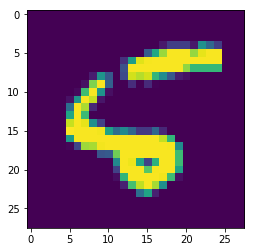

In [7]:
# visualize the prediction
prediction_num = 8
prediction = model.predict(x_test[0:10, :, :, :])
plt.imshow(x_test[prediction_num,:,:,0])
np.argmax(predictions[prediction_num])